# Problem set 5: Spring 2023, starter
### Mushroom data

# Quick description

As you may know, mushrooms in the wild can be either tasty or poisonous.  This classification data set is based on some measurements from wild mushrooms and uses supervised learning to predict mushroom types.  It compares two basic early methods, logistic, and knn classification, and looks at ROC curves for each.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Core scikit learn cross validation tools also
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

## 0. Describe dataset

This first section loads and preprocesses the dataset for you, and presents some descriptive statistics.

In [2]:
# data from Kaggle: https://www.kaggle.com/uciml/mushroom-classification
# This is a pandas read csv function, mushroom will be a pandas dataframe
mushroom = pd.read_csv("mushrooms.csv")
mushroom.head()
print(mushroom.shape)

(8124, 23)


### 0.1 Data features

Attribute Information: (classes: edible=e, poisonous=p)

cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s

cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s

cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y

bruises: bruises=t,no=f

odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

gill-attachment: attached=a,descending=d,free=f,notched=n

gill-spacing: close=c,crowded=w,distant=d

gill-size: broad=b,narrow=n

gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y

stalk-shape: enlarging=e,tapering=t

stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?

stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s

stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s

stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

veil-type: partial=p,universal=u

veil-color: brown=n,orange=o,white=w,yellow=y

ring-number: none=n,one=o,two=t

ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z

spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y

population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y

habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

### 0.2 Data CleaningLChecking null values

In [3]:
mushroom.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

There's no null values in the dataset, and the dataset are in a good quality.

### 0.3 Exploratory Analysis

In [4]:
mushroom.shape

(8124, 23)

In [5]:
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [6]:
mushroom.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


## 0.4 Data Processing

### 0.4.1 separating X and y

In [7]:
# Set predictors and targets
# eliminate a bunch of features to make the problem harder,
#   and a little faster too
X = mushroom.iloc[:,1:6].copy()
y = mushroom.iloc[:,0].copy()
print(X.shape)
print(y.shape)

(8124, 5)
(8124,)


### 0.4.2 Label Encoding
* Map charcter labels to numbers for Scikit-learn

In [8]:
print(X.head())
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 
for col in X.columns:
    X[col] = le.fit_transform(X[col])
Encoder_y=LabelEncoder()
y = Encoder_y.fit_transform(y)
# y = 1 poisonous, 0 edible


# Standardized features (needed for knn)
Xmean = X.mean(axis=0)
Xstd  = X.std(axis=0)
# Add some noise to the predictors
X = (X-Xmean)/Xstd+np.random.normal(size=(X.shape[0],X.shape[1]),scale=0.25)

print(X.head())
print("Fraction poisonous:",y.mean())


  cap-shape cap-surface cap-color bruises odor
0         x           s         n       t    p
1         x           s         y       t    a
2         b           s         w       t    l
3         x           y         w       t    p
4         x           s         g       f    n
   cap-shape  cap-surface  cap-color   bruises      odor
0   1.229377    -0.309902  -0.489292  1.227982  1.271706
1   0.652927     0.337779   1.242662  1.352773 -1.382808
2  -2.281425     0.019006   1.459703  1.273628 -0.980422
3   1.068250     0.611289   1.560527  0.998851  0.553777
4   0.998830     0.092536  -0.254866 -0.972941  0.122321
Fraction poisonous: 0.48202855736090594


## 0.5 Python hint for part 8

Problem 8 involves a small bit of Python trickiness, which it will be helpful if I just show you.  Let's say you are given a vector x which has numbers sorted highest to lowest.  You want to find the smallest entry in x such that x>threshold. 

There may be some other better ways to do this.  If you know of any feel free to tell me about them.

In [9]:
# set x to 9 to 1
# Find index to smallest entry in x > 4.0
x = np.arange(start=9, stop = 0, step = -1)
print(x)

# where is a function that will do this for you
# Unfortunately it returns a strange tupple object so you need to 
# pull out the vector with the [0] subscript
selectGT4 = np.where(x>4.)[0]
print(selectGT4)

# Now index for smallest x greater than 4.0

j = selectGT4[-1] # last entry in set > 4

print(j,x[j])

[9 8 7 6 5 4 3 2 1]
[0 1 2 3 4]
4 5


# Problem set 5

## 1. Logistic Regression and its accuracy

Set up a logistic regression, do a single train_test_split with test_size = 0.25.  Logistic regression should be run with penalty="none" and solver="lbfgs". Set random_state = 20 for the train_test_split().  Note: This means that you could compare your results to your fellow students.  (why?)

print the train score and test score, and the mean for the target (y).

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

when we do random state with an integer. 
a fixed value will guarantee that same sequence of random numbers are generated each time we run the code, therefore will be able to compare with other students.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=20)
lr = LogisticRegression(penalty="none",solver="lbfgs",max_iter=2000)
lr.fit(X_train, y_train)

print("Train score:",lr.score(X_train,y_train))
print("Test score:",lr.score(X_test, y_test))
print('mean y test:',np.mean(y_test))
print('mean y train:',np.mean(y_train))
print('mean y all target:',y.mean())

Train score: 0.7641555883801083
Test score: 0.7528311176760216
mean y test: 0.4771048744460857
mean y train: 0.4836697849991794
mean y all target: 0.48202855736090594


## 2. Our more standard randomized cross-validation (25 runs, testsize = 0.25)

Do a standard monte-carlo run with a randomized cross validation using cross_validate(), and the logistic regression from the last part.

In [12]:
lr = LogisticRegression(penalty="none",solver="lbfgs",max_iter=2000)
nmc=25

shuffle = ShuffleSplit(n_splits = nmc, test_size = 0.25)
CVInfo = cross_validate(lr, X, y, cv=shuffle, return_train_score = True)
 # use cross_validate function 
print("training mean: ", (CVInfo['train_score']).mean())
print(" testing mean: ",(CVInfo['test_score']).mean())

training mean:  0.762731002790087
 testing mean:  0.761752831117676


## 3. Confusion matrix

For the train_test_split from problem 1, reestimate logistic on the training data, and find the confusion matrix, accuracy, precision, and recall, on the test data.

In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [14]:

lr.fit(X_train,y_train)
lr.predict(X_test)

array([0, 1, 1, ..., 1, 0, 1])

In [15]:
#Confusion Matrix
yhat = lr.predict(X_test)
cmat = confusion_matrix(y_test, yhat)
tn, fp, fn, tp = cmat.ravel()
print(cmat)

[[802 260]
 [242 727]]


In [16]:
#accuracy, precision, and recall.
accuracy = (tn+tp)/(tn+tp+fn+fp)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Accuracy:",accuracy)
print("precision:",precision)
print("recall:",recall)

Accuracy: 0.7528311176760216
precision: 0.7365754812563323
recall: 0.7502579979360166


## 4. Threshold sweep

Using a logistic model fit on the training data, find the probabilities for y = 1 from the test data, and then do a sweep of thresholds from 0 to 0.95 using
np.arange(0.0,1.00,0.05)

For each threshold level find the predicted y value, and using this find the confusion matrix, and from this get precision, recall, and false positives.  Store those in lists along with the threshold values.  For false positives use the false positive rate which is fp/(fp+tn) which is also the type I error probability.

Plot the three values, precision, recall, and false positive rate (type I error) as a function of threshold.

Note:  All I want here is the plot.  No need to print any of those intermediate results.

In [17]:

Threshold = np.arange(0.0,1,0.05)

thres_class = SGDClassifier(loss="log",max_iter=1000, tol=1e-3, random_state=42)
y_scores = cross_val_predict(thres_class, X_train, y_train, cv=3,method="decision_function")

In [34]:
Threshold

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [35]:
list_precision=[]
list_recall=[]
list_falsepositive=[]
for i in Threshold:
    NewThrelist=[] #new list to be appended 
    y_some_digit_pred = (y_scores> i)
    cmat = confusion_matrix(y_train,y_scores>i)
    tn, fp, fn, tp = cmat.ravel()
    precision= tp/(tp+fp)
    recall=tp/(tp+fn)
    false_positive=fp/(fp+tn)
    list_precision.append(precision)
    list_recall.append(recall)
    list_falsepositive.append(false_positive)
    

In [36]:
list_recall

[0.7624703087885986,
 0.7539871055310485,
 0.7431286053613845,
 0.7295554801493044,
 0.7193756362402444,
 0.7071598235493722,
 0.6942653545978962,
 0.682049541907024,
 0.665083135391924,
 0.6501526976586359,
 0.6331862911435358,
 0.6185951815405497,
 0.6029860875466576,
 0.5897522904648795,
 0.5738038683406854,
 0.5602307431286053,
 0.5453003053953173,
 0.5293518832711231,
 0.511367492365117,
 0.49134713267729896]

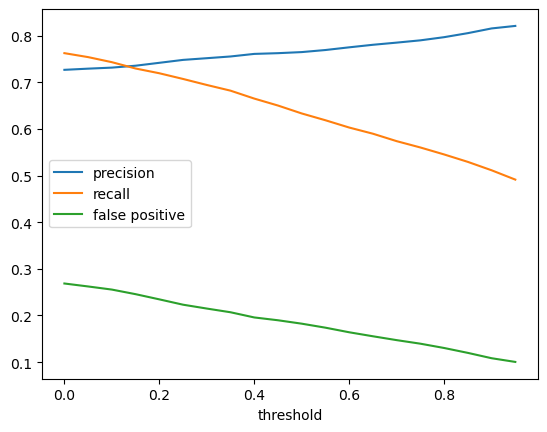

In [41]:
 #graphing precision, recall, false positive rate
plt.plot(Threshold, list_precision, label = "precision")
plt.plot(Threshold, list_recall, label = "recall")
plt.plot(Threshold, list_falsepositive, label = "false positive")
plt.legend()
plt.xlabel("threshold")
plt.show()

## 5. KNN Classifier and its accuracy

Set up a knn classifier.  Try to find the optimal neighbors by sweeping from 1 to 40.   Store training and test accuracy for each neighbor (as we've done many times).   Remember that you are recording the means across the multiple train/test splits.   These should be 25 runs, testsize=0.25, as in part 2.  Finally plot the accuracy for both test and training as a function of the number of neighbors.  Store the optimal neighbors in a variable,  best_neighbors.

In [42]:
lr = LogisticRegression(penalty="none",solver="lbfgs",max_iter=2000)
nmc=25  #run 25 iteration 
testScore = np.zeros(nmc)
trainScore = np.zeros(nmc)
for i in range(nmc):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    # Now run regression
    lr.fit(X_train, y_train)
    trainScore[i] = lr.score(X_train,y_train)
    testScore[i]  = lr.score(X_test,y_test)
    print('train mean:',np.mean(trainScore))
    print('test mean:',np.mean(testScore))
    
    


train mean: 0.03064500246184146
test mean: 0.030467749876907927
train mean: 0.06138191367142623
test mean: 0.06062038404726735
train mean: 0.09186935827999344
test mean: 0.09132447070408664
train mean: 0.12239619235187921
test mean: 0.1220876415558838
train mean: 0.1528836369604464
test mean: 0.15281142294436237
train mean: 0.18344986049565074
test mean: 0.18357459379615954
train mean: 0.21408173313638598
test mean: 0.21416051206302314
train mean: 0.24484490398818315
test mean: 0.24437223042836043
train mean: 0.2756277695716396
test mean: 0.27444608567208273
train mean: 0.3063318562284589
test mean: 0.3046774987690793
train mean: 0.33694403413753493
test mean: 0.3351452486459872
train mean: 0.36754308222550464
test mean: 0.36579025110782865
train mean: 0.3981355654029214
test mean: 0.3963761693746923
train mean: 0.428649269653701
test mean: 0.4272968980797636
train mean: 0.459051370425078
test mean: 0.45851304775972423
train mean: 0.4898539307401937
test mean: 0.4884884293451502
train 

In [43]:
from sklearn.neighbors import KNeighborsClassifier 
neighbors = list(np.arange(1,41,1))
train_neighbors=[]
test_neighbors=[]

for i in neighbors: # set a for loop inside Knnnclassifier 
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    train_neighbors.append(knn.score(X_train, y_train))
    test_neighbors.append(knn.score(X_test, y_test))

/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

Text(0.5, 0, 'test/train neighbors vs neighbors')

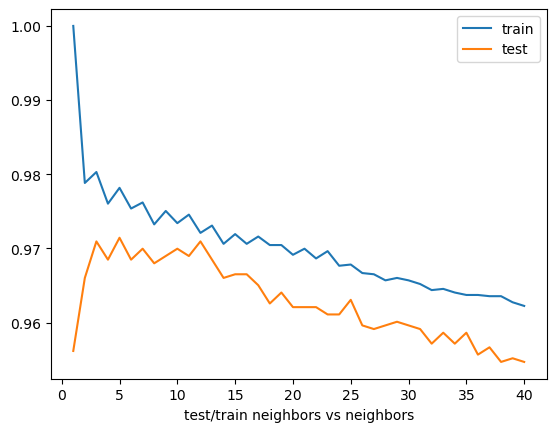

In [44]:
plt.plot(neighbors, train_neighbors, label = "train")
plt.plot(neighbors, test_neighbors,label = "test")
plt.legend()
plt.xlabel('test/train neighbors vs neighbors')


In [45]:
 #use the argmax in numpy to find the maximum value
n_best_neighbors = np.argmax(test_neighbors)
best_neighbors = neighbors[n_best_neighbors]# use the maximum value to locate the x index, same with the graph
best_neighbors

5

## 6. KNN classifier accuracy 

As a quick check run your "best_neighbors" classifer on the original data set from part 1, and report the mean train and test scores across many randomized cross-validations.  (Again, 25 runs, testsize = 0.25.)

In [46]:
knn_neighbors = KNeighborsClassifier(n_neighbors = best_neighbors)
knn_neighbors.fit(X_train, y_train)
print("original train: ", knn.score(X_train, y_train))
print("original test: ", knn.score(X_test, y_test))


original train:  0.9622517643197112
original test:  0.9547021171836534


/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/yuxuanzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

## 7. Threshold sweep

Repeat the threshold sweep from part 4, plotting precision, recall, and false positives for the knn classifier with
best_neighbors from 5.  Trained on the training sample (part 1), and all values estimated on the test sample (part 1).  Plot the same plot from part 4 for knn.  How do the two plots compare?  Which method looks better?

In [47]:
knn_neighbors = KNeighborsClassifier(n_neighbors = best_neighbors)
knn_neighbors.fit(X_train, y_train)

KNeighborsClassifier()

In [48]:

threshold=np.arange(0.0,1.00,0.05)

knnlist_precision=[]
knnlist_recall=[]
knnlist_falsepositive=[]

for i in threshold:   #do the same step but let the second argument of confusion matrix be yhat
    yhat = knn_neighbors.predict_proba(X_test)[:,1] > i
    cmat = confusion_matrix(y_test, yhat)
    tn, fp, fn, tp = cmat.ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    false_positive = fp/(fp+tn)
    knnlist_precision.append(precision)
    knnlist_recall.append(recall)
    knnlist_falsepositive.append(false_positive)

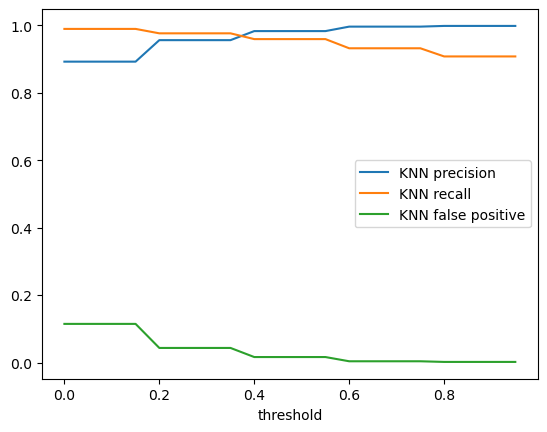

In [49]:
plt.plot(threshold, knnlist_precision, label = "KNN precision")
plt.plot(threshold, knnlist_recall, label = "KNN recall")
plt.plot(threshold, knnlist_falsepositive, label = "KNN false positive")
plt.legend()
plt.xlabel("threshold")
plt.show()

It looks like the ones for knn, false positive and precision experience a steeper decrease/increase at the beginning when we counting threshold

## 8. ROC curves and AUC

Plot the ROC curves (on the same plot) for the logistic classifier, and the knn classifier.  Get the probabilities using predict_proba on the test sample from part 1.  Use the roc_curve() to get the curve, and plot the two together.
Also, find the AUC (area under the curve) for both models.

Is there a definite winner in the race between these models?  Why or why not?

AUC for logistic: 0.8224886343130237
AUC for Knn classifier: 0.9910617094226056


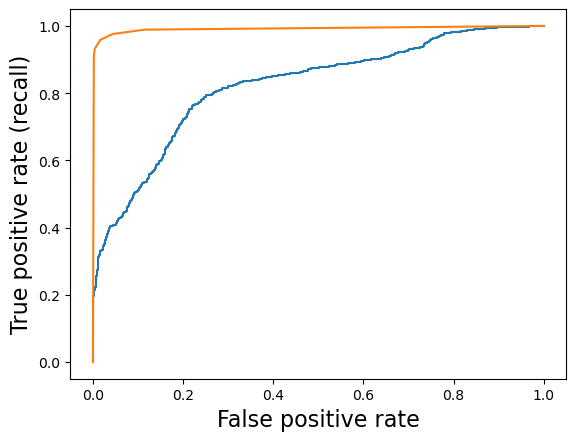

In [67]:
from sklearn.metrics import roc_curve

logistic_yhat=lr.predict_proba(X_test)[:,1]
Knn_yhat= knn_neighbors.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, logistic_yhat)
plt.plot(fpr,tpr)

plt.grid()
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate (recall)",fontsize=16)


#now let's do it for Knn
from sklearn.metrics import roc_auc_score
print("AUC for logistic:",roc_auc_score(y_test, logistic_yhat))

fpr, tpr, thresholds = roc_curve(y_test, Knn_yhat)
plt.plot(fpr,tpr)

plt.grid()
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate (recall)",fontsize=16) 


from sklearn.metrics import roc_auc_score
print("AUC for Knn classifier:",roc_auc_score(y_test, Knn_yhat))


Knn classifier has a better performance in distinguishing between true negative from true positive therefore a higher score compared to logistic model. Therefore Knn classifier is a winner 

## 9. Recall > 0.95 

For this problem I want you to find the best recall/false positive combination for each model, for a recall level greater than 0.95.  In other words you have been asked to deliver on a model that generates a 0.95 recall or better, and you want the model that does this with the smallest possible false positive rate.  What are these two rates for the logistic and knn models?  (I don't need to know any details about thresholds for this problem.  You can just use your recall, false positive lists from your plots.)

In [68]:
#for knn model


print("the least false_postive for knn when recall >95:",{fpr[np.where(tpr>.95)[0][0]]})

the least false_postive for knn when recall >95: {0.016377649325626204}


AUC for logistic: 0.8224886343130237


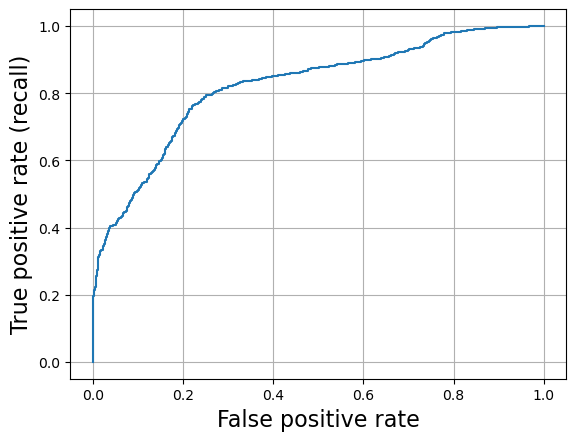

In [69]:
# i used same fpr, tpr variable therefore have to run the previous code again
fpr, tpr, thresholds = roc_curve(y_test, logistic_yhat)
plt.plot(fpr,tpr)

plt.grid()
plt.xlabel("False positive rate",fontsize=16)
plt.ylabel("True positive rate (recall)",fontsize=16)


#now let's do it for Knn
from sklearn.metrics import roc_auc_score
print("AUC for logistic:",roc_auc_score(y_test, logistic_yhat))

In [71]:
#for logistic model
print("the least false_postive for lositic when recall recall_95_precision:",{fpr[np.where(tpr>.95)[0][0]]})

the least false_postive for lositic when recall recall_95_precision: {0.7379576107899807}
